In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys


def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)


this_dir = osp.dirname('../../train.py')

lib_path = osp.join(this_dir, 'lib')
add_path(lib_path)

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
import torch
from utils.dataloader import CERN_Dataset_V3, UMASS_Dataset_V2
from torch.utils.data import DataLoader
from models.models import HAE, AE, SCSAE

In [4]:
ae_48_cern = "../../model_param/state_1930060.pt"
hae_48_cern = "../../model_param/state_7355990.pt"
scsae_48_cern = "../../model_param/state_6603495.pt"

### CER

Load models and dset

In [5]:
ae_model = AE(dropout = 0.1, latent_n = 48, input_days = 12, wide_freq = 48)
ae_model.load_state_dict(torch.load(ae_48_cern)['state_dict'])
ae_model.eval()
hae_model = HAE(latent_n = 48, input_days = 12, wide_freq = 48, reshape_factor = 1)
hae_model.load_state_dict(torch.load(hae_48_cern)['state_dict'])
hae_model.eval()
scsae_model = SCSAE(latent_n = 48, input_days = 12, wide_freq = 48, reshape_factor = 2)
scsae_model.load_state_dict(torch.load(scsae_48_cern)['state_dict'])
scsae_model.eval()
print('loaded')

loaded


In [6]:
ae_test_set = CERN_Dataset_V3(train = True, no_days = 12, reshape_factor = 2, mode = 'fc')
hae_test_set = CERN_Dataset_V3(train = True, no_days = 12, reshape_factor = 1, mode = 'cnn')
scsae_test_set = CERN_Dataset_V3(train = True, no_days = 12, reshape_factor = 2, mode = 'cnn')
ae_loader = DataLoader(ae_test_set, batch_size = 1)
hae_loader = DataLoader(hae_test_set, batch_size = 1)
scsae_loader = DataLoader(scsae_test_set, batch_size = 1)

100%|███████████████████████████████████████| 1800/1800 [02:08<00:00, 13.96it/s]


In [9]:
len(ae_test_set)

9000

Run models

In [10]:
criterion = torch.nn.MSELoss()
all_mse = pd.DataFrame(columns=['model', 'example', 'mse'])

In [11]:
for i in range(1):
    start_time = time.time()
    losses = []
    for data, data_noise in ae_loader:
        y, _ = ae_model(data)
        loss = criterion(y, data_noise).item()
        losses.append(loss)
    print("--- %s seconds ---" % (time.time() - start_time))
    
all_mse = pd.concat([all_mse, pd.DataFrame({'model':'ae','example':range(9000), 'mse':losses})], axis=0)

--- 3.022932529449463 seconds ---


In [12]:
for i in range(1):
    start_time = time.time()
    losses = []
    for data, data_noise in hae_loader:
        y, _ = hae_model(data)
        loss = criterion(y, data_noise).item()
        losses.append(loss)
    print("--- %s seconds ---" % (time.time() - start_time))    

all_mse = pd.concat([all_mse, pd.DataFrame({'model':'hae','example':range(9000), 'mse':losses})], axis=0)

--- 15.937028408050537 seconds ---


In [13]:
for i in range(1):
    start_time = time.time()
    losses = []
    for data, data_noise in scsae_loader:
        y, _ = scsae_model(data)
        loss = criterion(y, data_noise).item()
        losses.append(loss)
    print("--- %s seconds ---" % (time.time() - start_time))

all_mse = pd.concat([all_mse, pd.DataFrame({'model':'scsae','example':range(9000), 'mse':losses})], axis=0)

--- 9.641806840896606 seconds ---


In [14]:
all_mse = all_mse.reset_index(drop=True)
all_mse = all_mse.pivot(index='example', columns='model', values='mse')

In [15]:
# best examples
(all_mse.hae - all_mse.scsae).sort_values()[:5]

example
166    -0.007981
720    -0.006313
3040   -0.006214
7031   -0.005386
2013   -0.005284
dtype: float64

In [16]:
# worst examples
(all_mse.hae - all_mse.scsae).sort_values(ascending=False)[:5]

example
5867    0.016213
1689    0.005740
2097    0.005112
6849    0.004819
5870    0.004540
dtype: float64

##### Show examples

In [17]:
def show_example(record):
    
    test_record_ae = ae_test_set.cern_data[record]
    test_record_scsae = scsae_test_set.cern_data[record]
    test_record_hae = hae_test_set.cern_data[record]

    test_record_orig = test_record_ae.numpy()
    
    ae_test_out, _ = ae_model(test_record_ae.unsqueeze(0))
    scsae_test_out, _ = scsae_model(test_record_scsae.unsqueeze(0))
    hae_test_out, _ = hae_model(test_record_hae.unsqueeze(0))

    ae_test_out = ae_test_out.reshape(576).detach().numpy()
    scsae_test_out = scsae_test_out.reshape(576).detach().numpy()
    hae_test_out = hae_test_out.reshape(576).detach().numpy()
    
    fig, ax = plt.subplots(figsize=(14,6))

    for i in range(0, 576+48, 48):
        ax.axvline(x=i, color='black', alpha=.2)

    # ax.plot(ae_test_out, label='original')
    ax.plot(scsae_test_out, '-r', label='scsae', alpha=1, linewidth=1)
    ax.plot(hae_test_out, '-g', label='hae', alpha=1)
    ax.plot(test_record_orig, '-m', label='original', alpha=.6)
    ax.legend()
    title = 'Reconstruction. MSE: HAE {:.3f}, SCSAE: {:.3f}'.\
                format(all_mse.loc[record].hae, all_mse.loc[record].scsae)
    ax.set_title(title)
    plt.show()

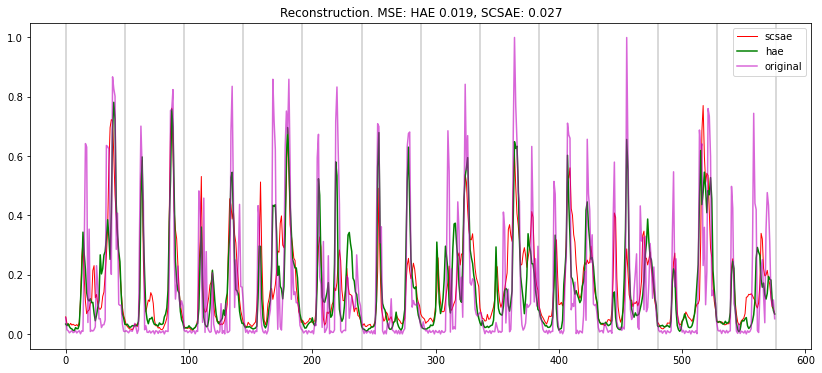

In [18]:
show_example(166)

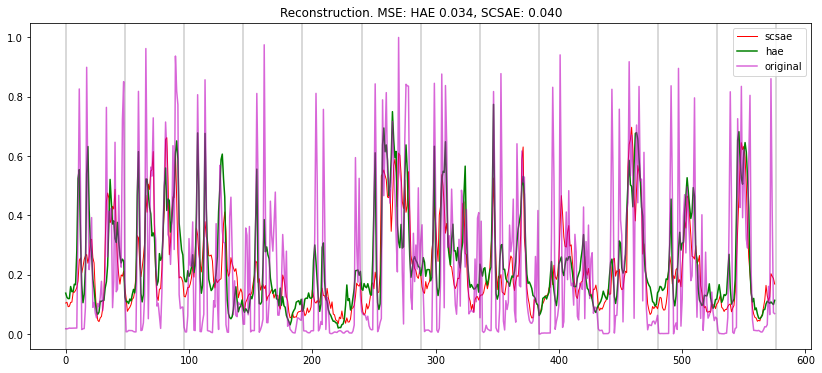

In [19]:
show_example(720)

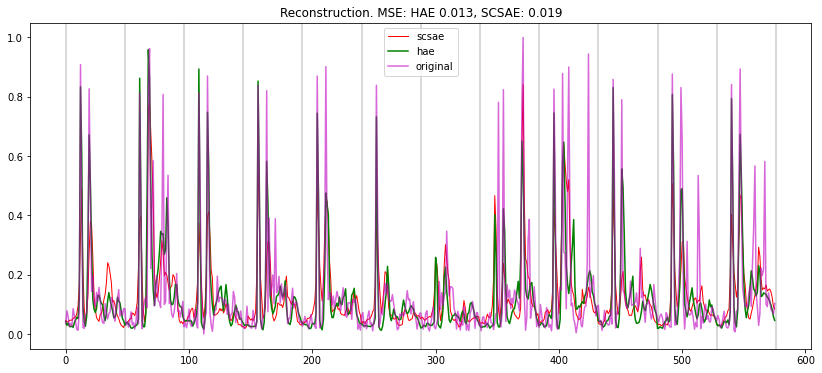

In [20]:
show_example(3040)

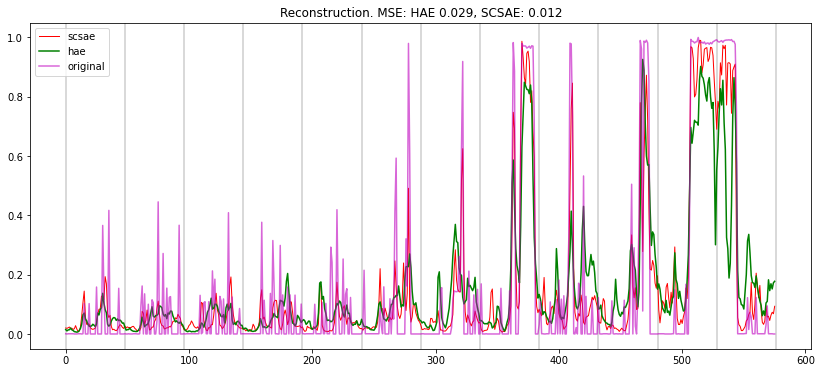

In [21]:
show_example(5867)

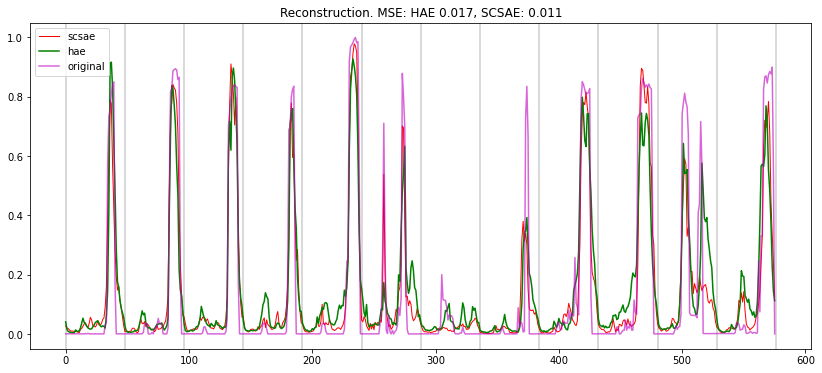

In [22]:
show_example(1689)

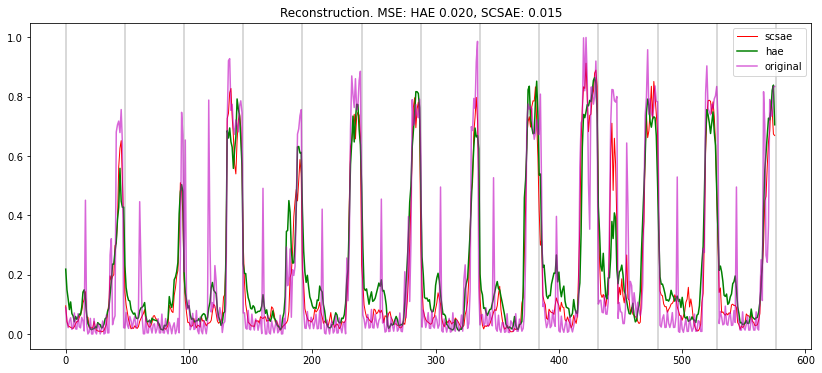

In [23]:
show_example(2097)

#### Show Distributions

In [24]:
all_mse_

NameError: name 'all_mse_' is not defined

<AxesSubplot:xlabel='value', ylabel='Density'>

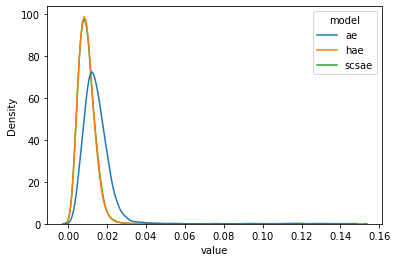

In [25]:
all_mse_ = all_mse.reset_index().melt(id_vars='example')
sns.kdeplot(data=all_mse_, hue='model', x='value', common_norm=False, multiple='layer')

### UMASS

In [190]:
range(0, 576, 48)

[0, 48, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528]